<a href="https://www.kaggle.com/code/maksudmalik/quora-question-classification?scriptVersionId=232695566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
import nltk
import xgboost as xgb
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
pd.set_option('display.max_colwidth', None)

In [3]:
train_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [4]:
train_df.shape

(1306122, 3)

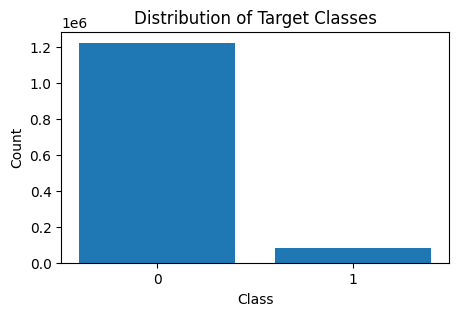

In [5]:
class_counts = train_df["target"].value_counts()
plt.figure(figsize=(5, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Target Classes")
plt.xticks([0, 1])
plt.show()

In [6]:
train_inputs, val_inputs, y_train, y_val = train_test_split(train_df.question_text, train_df.target, 
                                                                        test_size=0.3, random_state=42)

In [7]:
train_inputs.shape

(914285,)

# Manual Feature Extraction

In [8]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [9]:
def preprocess(doc):
    doc_stp=[[word for word in text.split(" ") if word.lower() not in english_stopwords]for text in doc]
    doc_stem=[[stemmer.stem(word) for word in words]for words in doc_stp]
    doc_final=[' '.join(words) for words in doc_stem]
    return doc_final
    
text_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess)),
    ('vectorize', TfidfVectorizer(max_features=50000))
])

In [10]:
%%time
x_train=text_pipeline.fit_transform(train_inputs)
x_val=text_pipeline.transform(val_inputs)
x_test=text_pipeline.transform(test_df.question_text)

CPU times: user 2min 55s, sys: 1.58 s, total: 2min 56s
Wall time: 2min 56s


In [11]:
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    device = "cuda"
)

In [12]:
%%time
model.fit(x_train, y_train)

CPU times: user 19.7 s, sys: 603 ms, total: 20.3 s
Wall time: 18 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [13]:
%%time
y_pred=model.predict(x_val)
f1_score(y_val, y_pred)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:39:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


CPU times: user 864 ms, sys: 8.99 ms, total: 873 ms
Wall time: 727 ms


0.3671026300743282

# Learned Representations

In [14]:
%%time
vocab = 50000
max_len = 120

tokenizer = Tokenizer(num_words=vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train_inputs)
sequences_train = tokenizer.texts_to_sequences(train_inputs)

padded_train_inputs = pad_sequences(sequences_train, maxlen=max_len, padding="post")

sequences_val = tokenizer.texts_to_sequences(val_inputs)
padded_val_inputs = pad_sequences(sequences_val, maxlen=max_len, padding="post")

sequences_test = tokenizer.texts_to_sequences(test_df.question_text)
padded_test_inputs = pad_sequences(sequences_test, maxlen=max_len, padding="post")

CPU times: user 41.2 s, sys: 413 ms, total: 41.6 s
Wall time: 41.6 s


In [15]:
embedd_size = 50
model = Sequential([
    Embedding(vocab, embedd_size),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [16]:
%%time
model.fit(padded_train_inputs, y_train, epochs=50, batch_size=256, verbose=1)

Epoch 1/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9469 - loss: 0.1414
Epoch 2/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9601 - loss: 0.0982
Epoch 3/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9716 - loss: 0.0706
Epoch 4/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9814 - loss: 0.0475
Epoch 5/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9863 - loss: 0.0347
Epoch 6/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9898 - loss: 0.0262
Epoch 7/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9917 - loss: 0.0210
Epoch 8/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9933 - loss: 0.0171
Epoch 9/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9947 - loss: 0.0137
Epoch 10/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9957 - loss: 0.0113
Epoch 11/50
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9963 - loss: 0.0097
Epoch 12/50
3572/35

In [17]:
y_pred=model.predict(padded_val_inputs)
y_pred_binary = (y_pred >= 0.5).astype(int)
f1_score(y_val, y_pred_binary)

12245/12245 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


0.5052618097210066

# Submission

In [18]:
sub_pred=model.predict(padded_test_inputs)
sub_pred_binary = (sub_pred >= 0.5).astype(int)

11744/11744 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


In [19]:
submissionfile = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/sample_submission.csv')
submissionfile['prediction']= sub_pred_binary
submissionfile.to_csv('submission.csv', index = False)

In [20]:
submissionfile

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0
